### Description
This notebook explores variability and quanity of pH data across time in order to create reasonable time bins to spatially interpolate within. February 2020 had a significantly lower amount of points than other months (7 unique stations when the average was 11)

In [1]:
import pandas as pd
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt

### Get data

In [2]:
# Read the data and parse the PROF_DATE_TIME_LOCAL column to a datetime object
data = pd.read_csv('../data/concat/MWRA_TA_DIC_2017_to_2022.csv',
parse_dates=['PROF_DATE_TIME_LOCAL'])
date_form = DateFormatter("%m/%y")

In [3]:
# Use predicted pH values
for ind, row in data.iterrows():
    ph = row['pH ()']
    ph_pred = row['pH out']
    if pd.isnull(ph) and not pd.isnull(ph_pred):
        data.loc[ind, 'pH ()'] = ph_pred

# Retrieve the good pH data
all = data[(data['pH ()'].notnull())
& (data['VAL_QUAL'].isnull())]

# drop the duplicates as pH is not unique
all.drop_duplicates(subset = ['PROF_DATE_TIME_LOCAL', 'DEPTH (m)', 'LATITUDE', 'LONGITUDE'], keep='first', inplace=True)

all['BIN_FIELD'] = [f'{date.month}_{date.year}' for date in all['PROF_DATE_TIME_LOCAL']]

# Retrieve the data for the shallow, deep
shallow = all[all['ORDERED_DEPTH_CODE'] == 'A']
deep = all[all['ORDERED_DEPTH_CODE'] == 'E']

<ipython-input-3-46f7331db156>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all.drop_duplicates(subset = ['PROF_DATE_TIME_LOCAL', 'DEPTH (m)', 'LATITUDE', 'LONGITUDE'], keep='first', inplace=True)
<ipython-input-3-46f7331db156>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all['BIN_FIELD'] = [f'{date.month}_{date.year}' for date in all['PROF_DATE_TIME_LOCAL']]


In [4]:
shallow.to_csv('cleaned_ph_A.csv')
deep.to_csv('cleaned_pH_E.csv')

### Plot pH across time for shallow/deep

<Figure size 1080x1080 with 0 Axes>

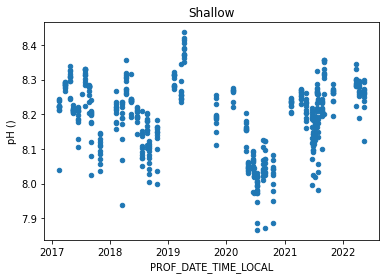

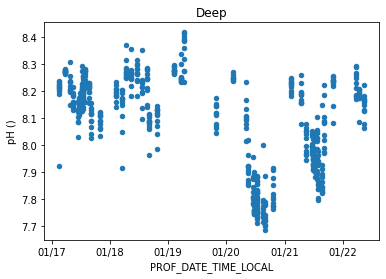

In [5]:
# Plot all time pH for the shallow and deep
fig = plt.figure() 
fig.set_size_inches(15, 15)
shallow.plot(x = 'PROF_DATE_TIME_LOCAL', y='pH ()', title='Shallow', kind = 'scatter')
deep.plot(x = 'PROF_DATE_TIME_LOCAL' , y='pH ()', title='Deep', kind = 'scatter')
plt.gca().xaxis.set_major_formatter(date_form)

### Moving STD, MEAN window with approx. 1 month of data per window

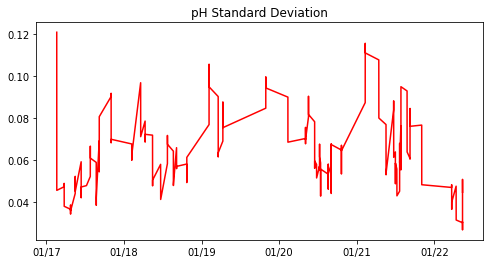

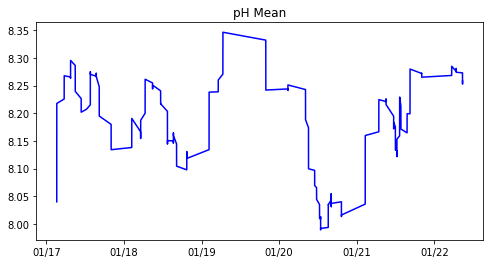

In [6]:
all.set_index('PROF_DATE_TIME_LOCAL', inplace=True, drop=False)
pH = all[all['SAMPLE_DEPTH_CODE'] == 'A']['pH ()'].to_frame()
# Standard deviation of the pH values
pH['STDEV window'] = pH['pH ()'].ewm(span=20).std()
pH['MEAN window'] = pH['pH ()'].ewm(span=20).mean()
fig = plt.figure()
fig.set_size_inches(8, 4)

plt.plot(pH.index, pH['STDEV window'], 'r-')
plt.title('pH Standard Deviation')
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

fig = plt.figure()
fig.set_size_inches(8, 4)
plt.plot(pH.index, pH['MEAN window'], 'b-')
plt.title('pH Mean')
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()


### Crop the window down to October 2019 to May 2020

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


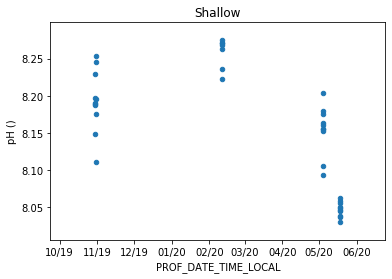

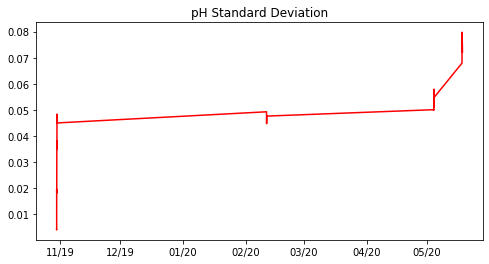

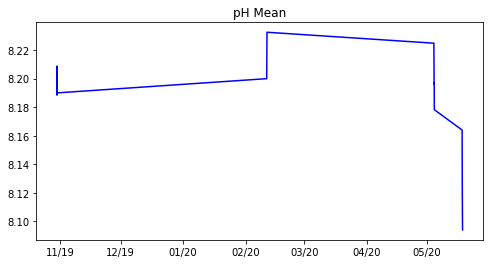

In [92]:
cropped = all[(all['PROF_DATE_TIME_LOCAL'] > '2019-10-01')
& (all['PROF_DATE_TIME_LOCAL'] < '2020-05-31')
& (all['SAMPLE_DEPTH_CODE'] == 'A')]

cropped.plot(x = 'PROF_DATE_TIME_LOCAL', y='pH ()', title='Shallow', kind = 'scatter')
plt.gca().xaxis.set_major_formatter(date_form)

pH = cropped['pH ()'].to_frame()
# Standard deviation of the pH values
pH['STDEV window'] = pH['pH ()'].ewm(span=20).std()
pH['MEAN window'] = pH['pH ()'].ewm(span=20).mean()
fig = plt.figure()
fig.set_size_inches(8, 4)

plt.plot(pH.index, pH['STDEV window'], 'r-')
plt.title('pH Standard Deviation')
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

fig = plt.figure()
fig.set_size_inches(8, 4)
plt.plot(pH.index, pH['MEAN window'], 'b-')
plt.title('pH Mean')
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

### Examine data by month

In [82]:
# Create binning field
shallow['BIN_FIELD'] = [f'{date.month}/{date.year}' for date in shallow['PROF_DATE_TIME_LOCAL']]
deep['BIN_FIELD'] = [f'{date.month}/{date.year}' for date in deep['PROF_DATE_TIME_LOCAL']]

<ipython-input-82-0782cf47d194>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shallow['BIN_FIELD'] = [f'{date.month}/{date.year}' for date in shallow['PROF_DATE_TIME_LOCAL']]
<ipython-input-82-0782cf47d194>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep['BIN_FIELD'] = [f'{date.month}/{date.year}' for date in deep['PROF_DATE_TIME_LOCAL']]


In [70]:
stats_dict = {}
for name, group in shallow.groupby('BIN_FIELD', sort = False):
    #group.plot(x = 'LATITUDE', y = 'LONGITUDE', kind = 'scatter', title = f'{name} (A)')
    stats_dict[name] = {'points': len(group), 'stations': len(group['STAT_ID'].unique())}
    #print(f'{name}: {len(group)}')

In [71]:
# From the dictionary, get the least number of points
min_points = min([stats_dict[key]['points'] for key in stats_dict])

# Get the month name with the min number of points
min_points_month = [key for key in stats_dict if stats_dict[key]['points'] == min_points][0]

print(f'The month with the least number of points is {min_points_month} with {min_points} points')

# From the dictionary, get the least number of stations
min_stations = min([stats_dict[key]['stations'] for key in stats_dict])

# Get the station name with the min number of points
min_stations_month = [key for key in stats_dict if stats_dict[key]['stations'] == min_stations][0]

print(f'The month with the least number of stations is {min_stations_month} with {min_stations} stations')

# From the dictionary, get the the most number of points
max_points = max([stats_dict[key]['points'] for key in stats_dict])

# Get the month name with the max number of points
max_points_month = [key for key in stats_dict if stats_dict[key]['points'] == max_points][0]

print(f'The month with the most number of points is {max_points_month} with {max_points} points')

# From the dictionary, get the most number of stations
max_stations = max([stats_dict[key]['stations'] for key in stats_dict])

# Get the month name with the max number of points
max_stations_month = [key for key in stats_dict if stats_dict[key]['stations'] == max_stations][0]

print(f'The month with the most number of stations is {max_stations_month} with {max_stations} stations')

# Get the mean number of points per month
mean_points = [stats_dict[key]['points'] for key in stats_dict]
mean_points = sum(mean_points) / len(mean_points)
print(f'The mean number of points per month is {mean_points}')

# Get the mean number of stations per month
mean_stations = [stats_dict[key]['stations'] for key in stats_dict]
mean_stations = sum(mean_stations) / len(mean_stations)
print(f'The mean number of stations per month is {mean_stations}')

The month with the least number of points is 2/2020 with 7 points
The month with the least number of stations is 2/2020 with 7 stations
The month with the most number of points is 7/2021 with 57 points
The month with the most number of stations is 7/2021 with 20 stations
The mean number of points per month is 12.625
The mean number of stations per month is 11.325


### Plot monthly points

In [84]:
# Plot monthly shallow
for name, group in shallow.groupby('BIN_FIELD', sort = False):
    #group.plot(x = 'LATITUDE', y = 'LONGITUDE', kind = 'scatter', title = f'{name} (A)')

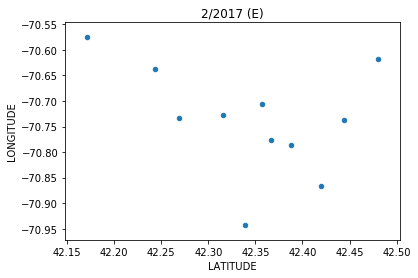

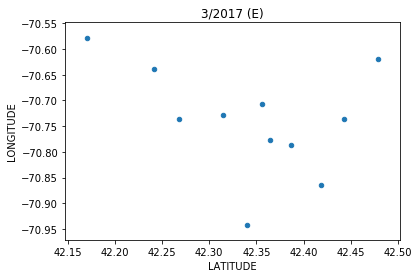

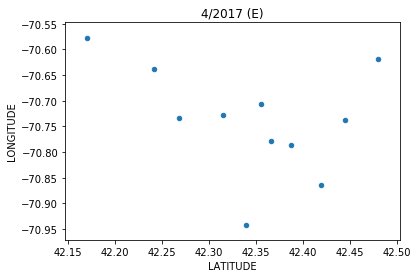

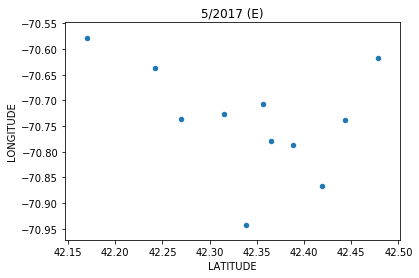

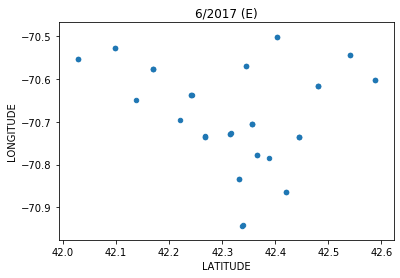

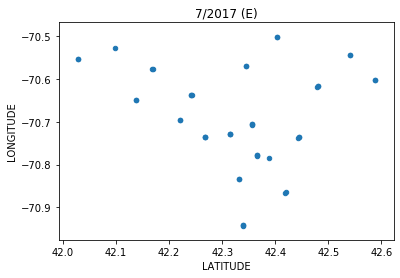

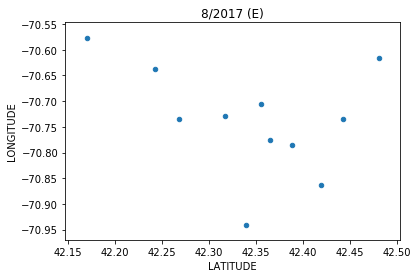

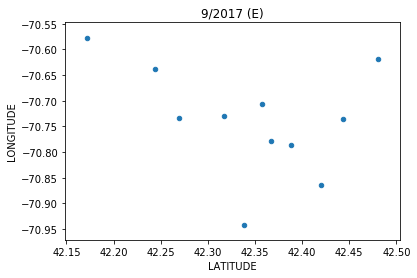

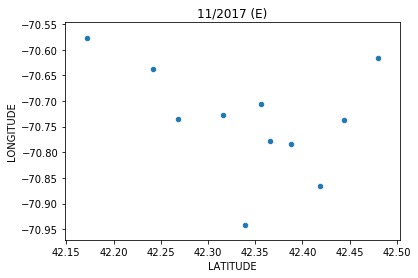

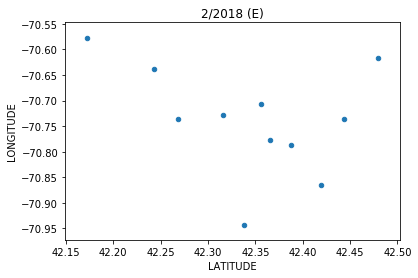

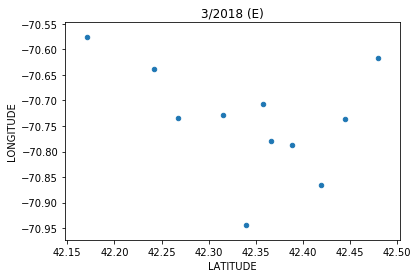

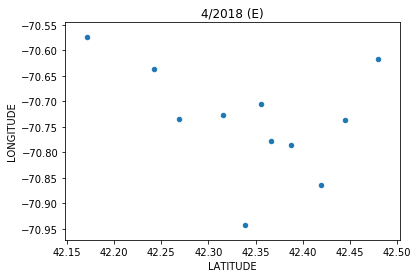

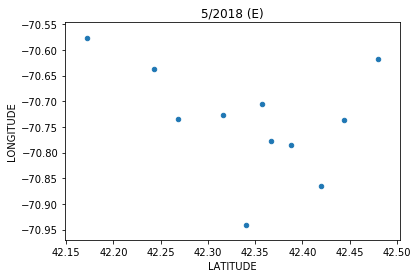

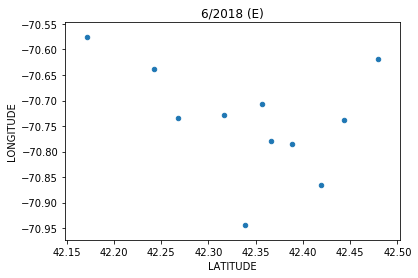

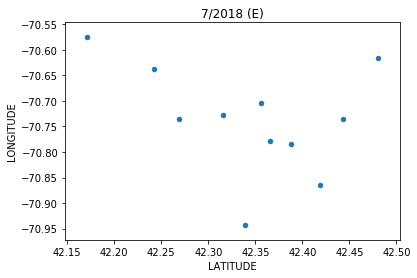

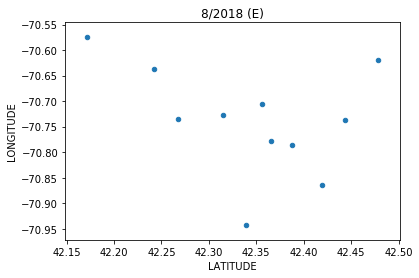

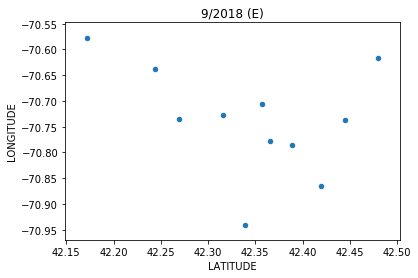

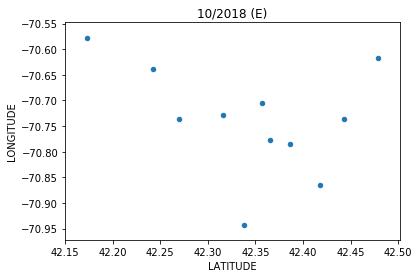

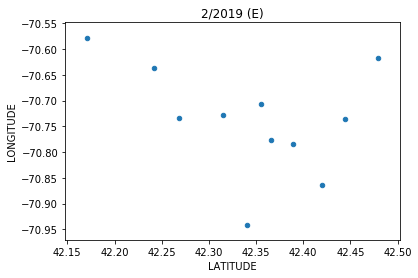

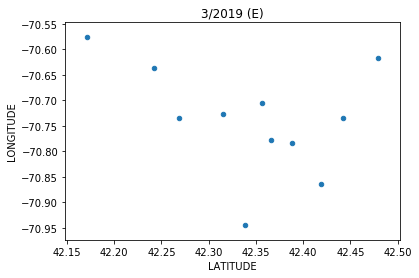

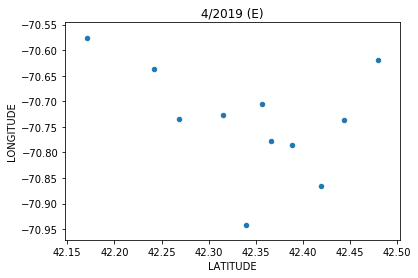

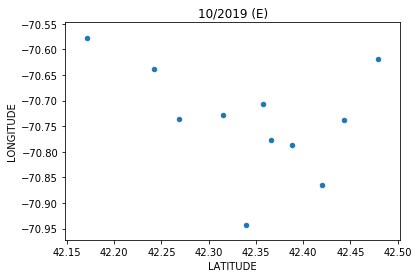

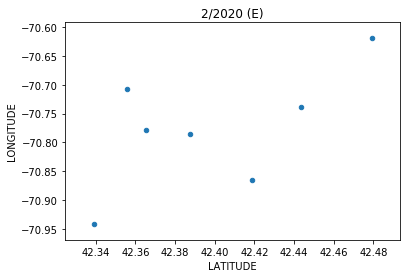

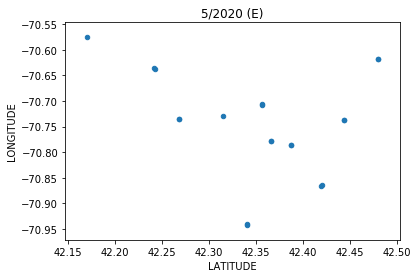

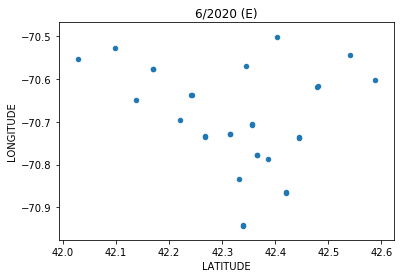

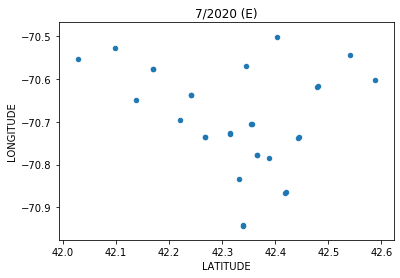

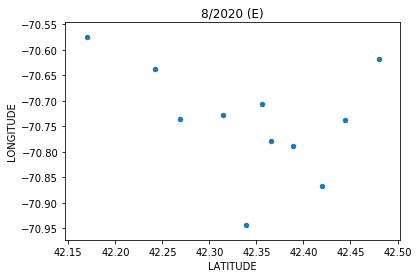

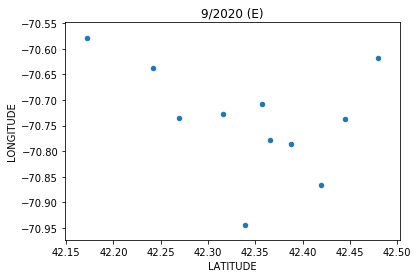

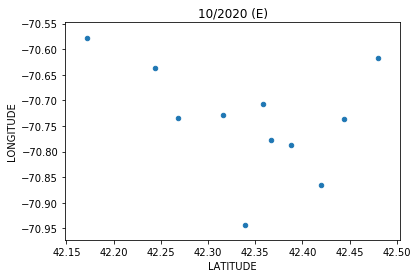

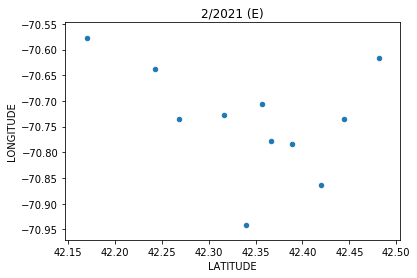

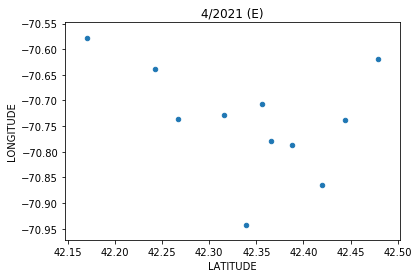

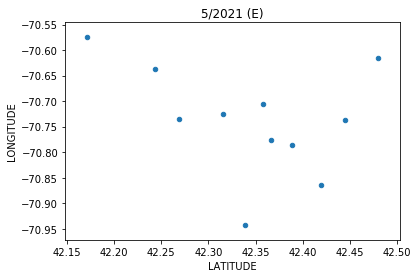

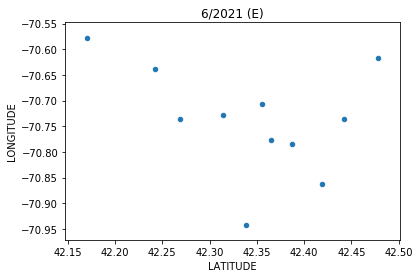

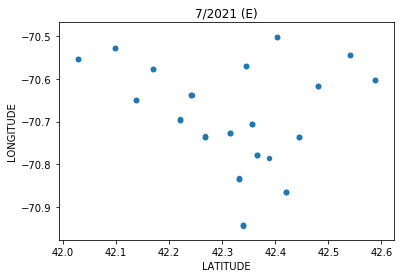

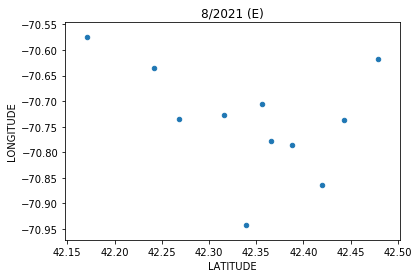

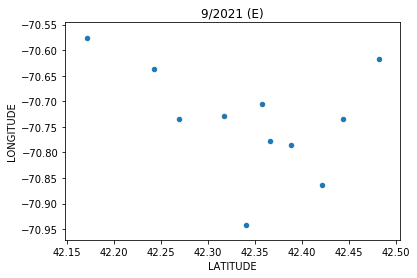

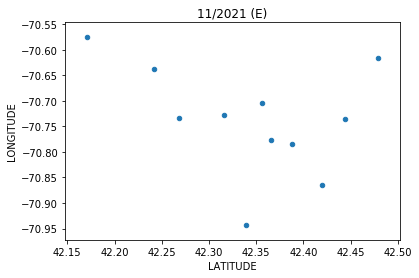

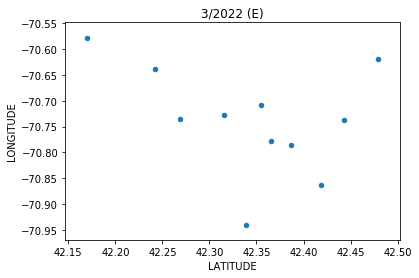

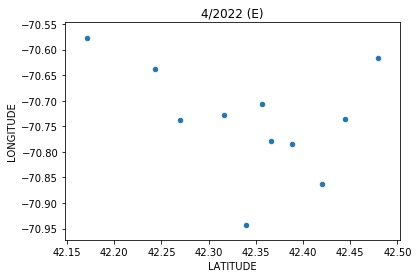

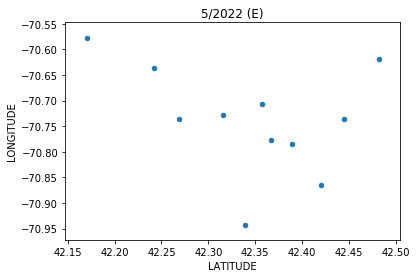

In [86]:
# Plot monthly deep
for name, group in deep.groupby('BIN_FIELD', sort = False):
  group.plot(x = 'LATITUDE', y = 'LONGITUDE', kind = 'scatter', title = f'{name} (E)')